In [158]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_ta as ta
#Data Import
import yfinance as yf
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [159]:
# Data Download 
ticker_symbol = '^NSEI'
df = yf.download(ticker_symbol, period='max', progress=False)

In [160]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2007-09-17,4494.649902,4549.049805,4482.850098,4518.450195,0
2007-09-18,4546.200195,4551.799805,4481.549805,4494.100098,0
2007-09-19,4732.350098,4739.000000,4550.250000,4550.250000,0
2007-09-20,4747.549805,4760.850098,4721.149902,4734.850098,0
2007-09-21,4837.549805,4855.700195,4733.700195,4752.950195,0


### Making df_modifed for Model 1 (Next day prediction model)
#### For present day we will create new model with new data 

In [161]:
## Copy of Dataframe to work in
df_modified = df.copy()

In [162]:
# We flatten the columns to ensure they are simple and single-level.
if isinstance(df_modified.columns, pd.MultiIndex):
    df_modified.columns = df_modified.columns.get_level_values(0)
else:
    print("Columns are already single-level. No flattening needed.")

In [163]:
# Add all engineered features to the modified DataFrame

df_modified['Daily Return'] = df_modified['Close'].pct_change()
df_modified['MA50'] = df_modified['Close'].rolling(window=50).mean()
df_modified['MA200'] = df_modified['Close'].rolling(window=200).mean()
df_modified['RSI'] = ta.rsi(df_modified['Close'], length=14)


In [164]:
df_modified.tail()

Price,Close,High,Low,Open,Volume,Daily Return,MA50,MA200,RSI
Date,,,,,,,,,
2025-07-31,24768.349609,24956.500000,24635.000000,24642.250000,346300,-0.003488,25057.622070,24053.279277,40.914833
2025-08-01,24565.349609,24784.150391,24535.050781,24734.900391,263400,-0.008196,25051.866055,24050.466279,36.006905
2025-08-04,24722.750000,24736.250000,24554.000000,24596.050781,259300,0.006407,25046.298047,24048.793281,41.833134
2025-08-05,24649.550781,24733.099609,24590.300781,24720.250000,251800,-0.002961,25042.765078,24047.184531,40.008836
2025-08-06,24574.199219,24671.400391,24539.199219,24641.349609,0,-0.003057,25039.200078,24046.306279,38.163831


In [165]:
# Check how many missing (NaN) values are in each column

df_modified.isnull().sum()

Price
Close             0
High              0
Low               0
Open              0
Volume            0
Daily Return      1
MA50             49
MA200           199
RSI              14
dtype: int64

In [166]:
# shape before dropping nan value
df_modified.shape

(4388, 9)

In [167]:
# Drop rows with any NaN values directly from df_modified
df_modified.dropna(inplace=True)

In [168]:
# shape after dropping 
df_modified.shape

(4189, 9)

#### Preparing X and Y variables For Model 1 (Next day Prediction)

In [169]:
# Define Independent Variables 
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily Return', 'MA50', 'MA200', 'RSI']
X = df_modified[features]

# Define Dependent Variable
y = df_modified['Close'].shift(-1)

X = X[:-1]
y = y[:-1]


In [170]:
X.head()

Price,Open,High,Low,Close,Volume,Daily Return,MA50,MA200,RSI
Date,,,,,,,,,
2008-07-07,4002.000000,4114.500000,4002.000000,4030.000000,0,0.003486,4696.748003,5210.716744,36.417783
2008-07-08,4028.699951,4028.699951,3896.050049,3988.550049,0,-0.010285,4674.285000,5208.186245,35.188350
2008-07-09,3990.899902,4169.399902,3990.899902,4157.100098,0,0.042258,4655.634004,5206.240745,43.535805
2008-07-10,4155.649902,4187.950195,4110.399902,4162.200195,0,0.001227,4634.968008,5203.389995,43.771793
2008-07-11,4166.000000,4215.500000,4014.449951,4049.000000,0,-0.027197,4612.630010,5199.897246,39.796121


In [171]:
y.head()

Date
2008-07-07    3988.550049
2008-07-08    4157.100098
2008-07-09    4162.200195
2008-07-10    4049.000000
2008-07-11    4039.699951
Name: Close, dtype: float64

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

In [173]:
X_scaled_df.head()

Price,Open,High,Low,Close,Volume,Daily Return,MA50,MA200,RSI
Date,,,,,,,,,
2008-07-07,0.061128,0.064545,0.073195,0.063558,0.0,0.433825,0.085597,0.088840,0.323107
2008-07-08,0.062255,0.060923,0.068761,0.061808,0.0,0.389003,0.084592,0.088718,0.306186
2008-07-09,0.060659,0.066862,0.072730,0.068922,0.0,0.560019,0.083757,0.088624,0.421075
2008-07-10,0.067612,0.067645,0.077730,0.069138,0.0,0.426472,0.082832,0.088486,0.424323
2008-07-11,0.068049,0.068808,0.073715,0.064360,0.0,0.333959,0.081832,0.088318,0.369605


In [174]:
# Train test split 
train_size = int(len(X_scaled_df) * 0.8)

X_train, X_test = X_scaled_df[:train_size], X_scaled_df[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3350, 9)
X_test shape: (838, 9)
y_train shape: (3350,)
y_test shape: (838,)


#### Create an Evaluate Function to give all metrics after model Training

In [175]:
def evaluate_model(true, predicted):
    """
    Calculates and returns MAE, RMSE, and R2 Score.
    """
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [176]:
# Create a dictionary of the models we want to test
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Create empty lists to store model names and their R2 scores
model_list = []
r2_list = []

# Loop through each model in the dictionary
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on both training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model on both datasets
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Print the performance report for the current model
    print(model_name)
    model_list.append(model_name)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    # Append the test R2 score to our list
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 100.0354
- Mean Absolute Error: 67.3240
- R2 Score: 0.9992
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 174.9066
- Mean Absolute Error: 125.9584
- R2 Score: 0.9967


Lasso
Model performance for Training set
- Root Mean Squared Error: 109.8312
- Mean Absolute Error: 75.0907
- R2 Score: 0.9990
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 202.2365
- Mean Absolute Error: 148.3238
- R2 Score: 0.9956


Ridge
Model performance for Training set
- Root Mean Squared Error: 115.1147
- Mean Absolute Error: 77.7597
- R2 Score: 0.9989
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 193.7826
- Mean Absolute Error: 144.1606
- R2 Score: 0.9959


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 133.0677
- Mean Absolute Error: 91.0786
- R2 Score: 0.9986

### Results

In [177]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.996677
2,Ridge,0.995921
1,Lasso,0.995557
5,Random Forest Regressor,-0.776508
6,XGBRegressor,-0.795372
3,K-Neighbors Regressor,-0.839107
4,Decision Tree,-0.871185
7,CatBoost Regressor,-0.882871
8,AdaBoost Regressor,-1.085055


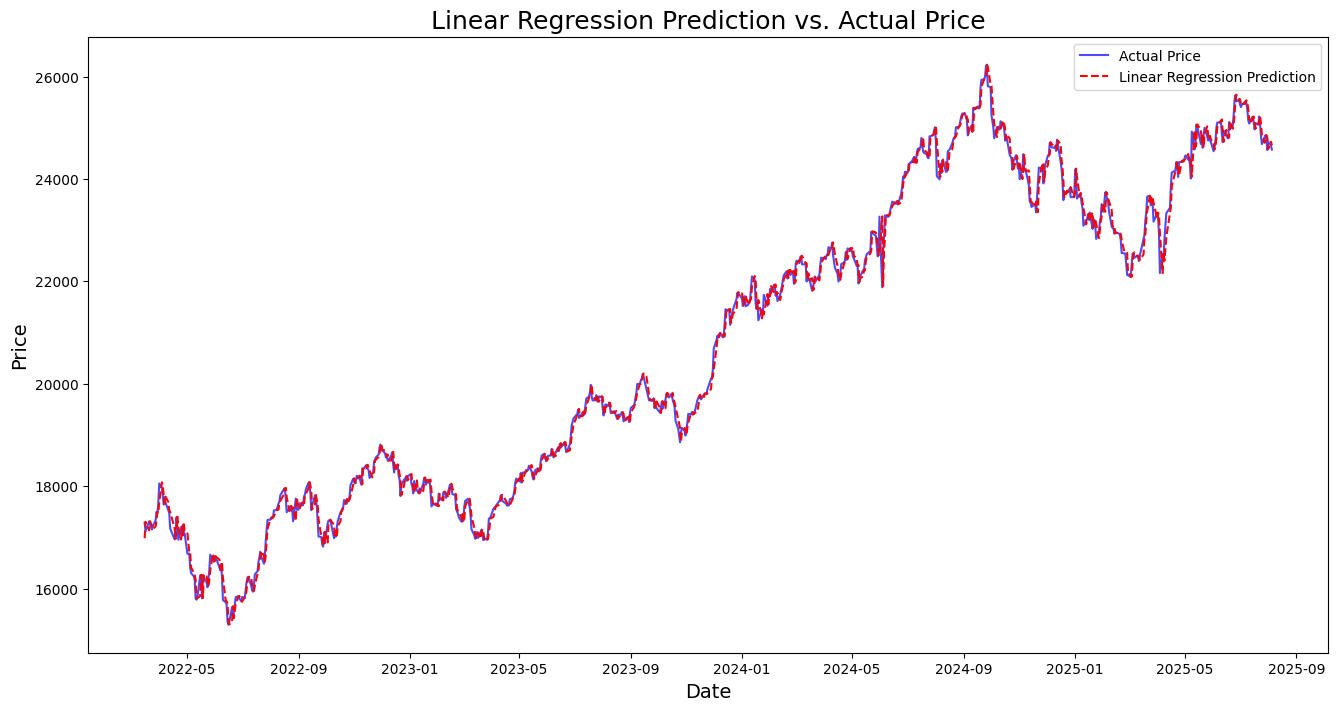

In [182]:
# best performing model Linear Regression
best_model = LinearRegression()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Create a new DataFrame for plotting the results
plot_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
}, index=y_test.index)

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(plot_df['Actual Price'], label='Actual Price', color='blue', alpha=0.7)
plt.plot(plot_df['Predicted Price'], label='Linear Regression Prediction', color='red', linestyle='--')
plt.title('Linear Regression Prediction vs. Actual Price', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.show()

Conclusion from ML Models: The high R2 score is misleading; the plot shows the model is only shadowing the price, not truly forecasting its direction.